In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from arch import arch_model
from arch.__future__ import reindexing

In [2]:
df = yf.download('^GSPC',start='1900-03-01', proxy='127.0.0.1:7890')
df.drop(columns=['Volume'],inplace=True)
df['return'] = 100*df['Adj Close'].pct_change()
df['log_return'] = 100*(np.log2(df['Adj Close']) - np.log2(df['Adj Close'].shift(1)))
df.dropna(inplace=True)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,return,log_return
Date,,,,,,,
1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0.566254,0.814627
1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,-0.225230,-0.325305
1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,-0.959368,-1.390758
1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0.626784,0.901436
1928-01-09,17.500000,17.500000,17.500000,17.500000,17.500000,-0.906001,-1.313041
...,...,...,...,...,...,...,...
2022-04-21,4489.169922,4512.939941,4384.470215,4393.660156,4393.660156,-1.475295,-2.144257
2022-04-22,4385.830078,4385.830078,4267.620117,4271.779785,4271.779785,-2.774005,-4.058601
2022-04-25,4255.339844,4299.020020,4200.819824,4296.120117,4296.120117,0.569794,0.819705


In [80]:
df['realized volatility'] = df['return'].rolling(22).std()
df.dropna(inplace=True)
df

,Open,High,Low,Close,Adj Close,return,log_return,realized volatility
Date,,,,,,,,
1930-05-07,23.309999,23.309999,23.309999,23.309999,23.309999,-1.893943,-2.758588,1.493600
1930-05-08,23.400000,23.400000,23.400000,23.400000,23.400000,0.386101,0.555953,1.497022
1930-05-09,23.690001,23.690001,23.690001,23.690001,23.690001,1.239320,1.776972,1.536419
1930-05-12,24.090000,24.090000,24.090000,24.090000,24.090000,1.688475,2.415617,1.541164
1930-05-13,24.420000,24.420000,24.420000,24.420000,24.420000,1.369863,1.962880,1.579477
...,...,...,...,...,...,...,...,...
2022-03-28,4541.089844,4575.649902,4517.689941,4575.520020,4575.520020,0.714496,1.027134,1.482212
2022-03-29,4602.859863,4637.299805,4589.660156,4631.600098,4631.600098,1.225655,1.757497,1.434337
2022-03-30,4624.200195,4627.770020,4581.319824,4602.450195,4602.450195,-0.629370,-0.910858,1.443096


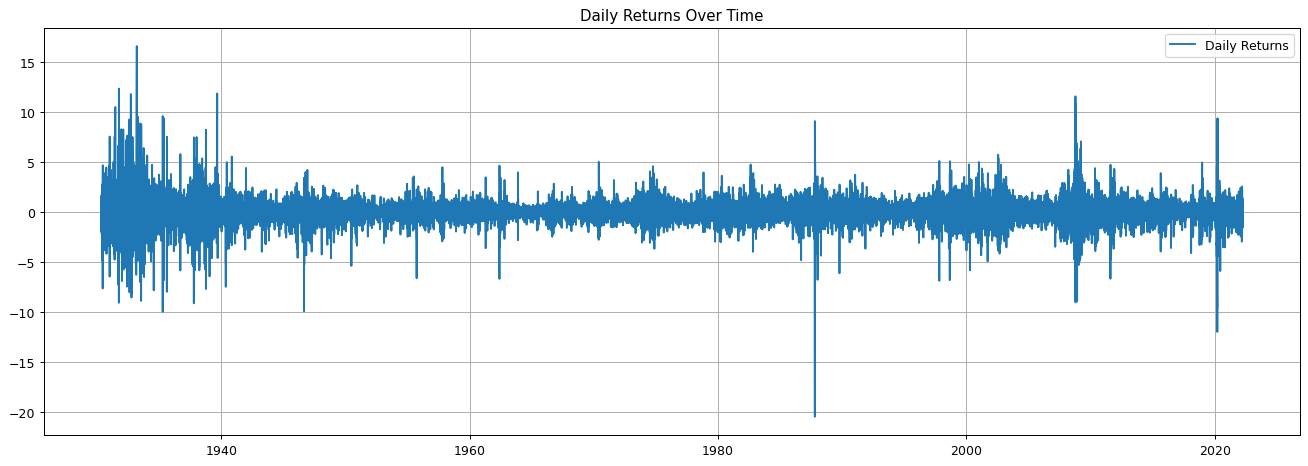

In [81]:

fig = plt.figure(figsize=(18,6),dpi=90)
plt.plot(df['return'], label = 'Daily Returns')
plt.legend()
plt.grid()
plt.title('Daily Returns Over Time')
plt.show()

In [83]:
daily_volatility = df['return'].std()
print('Daily volatility: ', '{:.4f}%'.format(daily_volatility))

monthly_volatility = np.sqrt(21) * daily_volatility
print ('Monthly volatility: ', '{:.4f}%'.format(monthly_volatility))

annual_volatility = np.sqrt(252) * daily_volatility
print ('Annual volatility: ', '{:.4f}%'.format(annual_volatility ))

Daily volatility:  1.1805%
Monthly volatility:  5.4097%
Annual volatility:  18.7396%


In [86]:
garch_model = arch_model(df['return'][-22:], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')

gm_result = garch_model.fit(disp='off')
print(gm_result.params)

print('\n')

gm_forecast = gm_result.forecast(horizon = 5)
print(np.sqrt(252)*gm_forecast.variance[-1:])

mu          2.092008e-01
omega       1.866664e-08
alpha[1]    0.000000e+00
beta[1]     9.691188e-01
Name: params, dtype: float64


                  h.1        h.2        h.3        h.4        h.5
Date                                                             
2022-04-01  16.787677  16.269254  15.766841  15.279943  14.808081


In [38]:
egarch_model = arch_model(df['MinMaxReturn'], p = 1, o=1, q = 1,
                      mean = 'constant', vol = 'EGARCH', dist = 'normal')

egm_result = egarch_model.fit(disp='off')
print(egm_result.params)

print('\n')

gm_forecast = egm_result.forecast(horizon = 1)
print(gm_forecast.variance[-1:])

mu          55.735791
omega        0.034423
alpha[1]     0.172220
gamma[1]    -0.071739
beta[1]      0.985436
Name: params, dtype: float64


                  h.1
Date                 
2022-04-01  11.825305


In [7]:

rolling_predictions = []
test_size = 252
for i in range(test_size):
    train = df['return'][:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_predictions = pd.Series(rolling_predictions, index=df['return'].index[-test_size:])

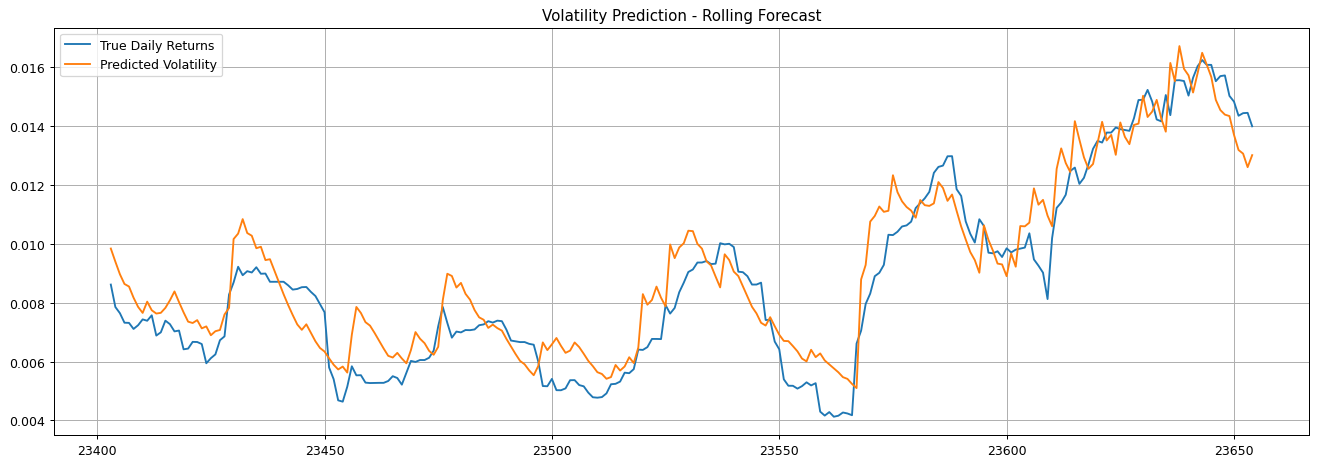

In [8]:

plt.figure(figsize=(18,6), dpi=90)
plt.plot(df['realized volatility'][-test_size:])
plt.plot(rolling_predictions)
plt.grid()
plt.title('Volatility Prediction - Rolling Forecast')
plt.legend(['True Daily Returns', 'Predicted Volatility'])
plt.show()

In [9]:
from sklearn import metrics
y = df['realized volatility'][-test_size:]/100
y_pre = rolling_predictions/100
print(metrics.r2_score(y, y_pre))
print(metrics.mean_squared_error(y, y_pre))

0.8837659301658526
1.1946835767854489e-06
